# <center> WinoGrad Schema Challenge <center/>

# Problem Description
In this section, we are to solve a Winograd Schema Challenge (WSC) task. In this task, you need to classify whether a pronoun in a sentence refers to option A or B. Here are two examples (the pronoun is replaced with a blank): <br><br>
Example 1: The plant took up too much room in the urn, because the _ was small. <br>
1. plant    
2. urn
***answer: 2*** <br><br>

Example 2: The plant took up too much room in the urn, because the _ was large.<br>
1. plant    
2. urn
***answer: 1***


In [1]:
#@title connect google drive folder
try:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/Winograd_Challenge
except:
    print('Not running on Google Colab')

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

!pip install transformers

Mounted at /content/drive
/content/drive/MyDrive/SMU_MITB_NLP/assignment2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 4.2 MB/s 
     |████████████████████████████████| 596 kB 3.4 MB/s 
     |████████████████████████████████| 86 kB 5.8 MB/s 
     |████████████████████████████████| 6.6 MB 50.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
#@title Packages and Dependencies
import transformers
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.optim import AdamW, lr_scheduler

import tqdm
import pickle
import csv
import os
from typing import List, Optional, Union
import json
import math
import re
import numpy as np
import matplotlib.pyplot as plt
transformers.logging.set_verbosity_error()

# Methodology
The main idea used to tackle this problem is to build a Deep Neural Network to classify the probability of observing the sentence when the blank is replaced by each candidate. For the example in the description, this means to construct 2 sentences by filling in the blanks: <br><br>
Initial Sentence:<br>
The plant took up too much room in the urn, because the _ was small.<br><br>
Candidate Sentence 1: <br>
The plant took up too much room in the urn, because the ***urn*** was small. <br><br>
Candidate Sentence 2: <br>
The plant took up too much room in the urn, because the ***plant*** was small. <br><br>

And pick the sentence which gives the higher probability P(Candidate Sentence | Initial Sentence). To do this, each candidate sentence is broken down into two sub-sentences to predict if the later portion is likely to be the next sub-sentence of the initial part. The blank token to be filled in is the start of the second half. <br><br>
For example for Candidate Sentence 1: <br><br>

First Part (Context): The plant took up too much room in the urn, because the <Br>
Second Part (Prediction): ***urn*** was small.<br>
Label (Ground Truth): 1 (True) <br><br>

RobertaForSequenceClassification was used to train and predict the probability of the two candidate sequence and pick the better candidate. For Candidate 1, the input token sequence is:<br>

'[CLS] The plant took up too much room in the urn, because the [SEP][SEP] urn was small.[SEP]' <br><br>

where [CLS] is start token, [SEP] is end token and [SEP][SEP] is the tokens between the two sub-sentences.<br><br>



In [3]:
#@title PreProcessing
class InputExample(object):
    
    def __init__(self, guid, sentence, text_a, text_b, label=None):
        self.guid = guid
        self.sentence = sentence
        self.candidate_1 = text_a
        self.candidate_2 = text_b
        self.label = label
        
    def __str__(self):
        if self.label != None:

            return "Guid: " + self.guid + "\nSentence:" + self.sentence + "\nCandidate_1: " + self.candidate_1 +\
                "\nCandidate_2: " + self.candidate_1 + "\nLabel: " + self.label
        else:
            return "Guid: " + self.guid + "\nSentence:" + self.sentence + "\nCandidate_1: " + self.candidate_1 +\
                "\nCandidate_2: " + self.candidate_1 + "\nLabel: None"
        

class InputFeatures(object):

    def __init__(self, input_ids, attention_mask, label=None):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.label = label

    def __str__(self):
        return "Input Ids: " + str(self.input_ids) + "\nAttention Mask:" + str(self.attention_mask) + "\nLabels: " + str(self.label)
        
class PreProcessor():
    
    def __init__(self):
        self.model_args = {'max_seq_length':64, 'verbose':False}

    def set_model_arg(self, key, value):
        self.model_args[key] = value
    
    def get_model_arg(self, key):
        return self.model_args.get(key, None)

    def save(self, path):
        f = open(path, 'wb')
        pickle.dump(self, f)
        f.close()

    def load(self, path):
        f = open(path, 'rb')
        proc = pickle.load(f)
        f.close()
        return proc

    def _read_jsonl(self, input_file):
        dataset = []
        with open(input_file, 'r') as json_file:
            for json_str in list(json_file):
                dataset.append(json.loads(json_str))
        return dataset

    def get_train_examples(self, data_dir):
        return self._create_examples(
            self._read_jsonl(os.path.join(data_dir, "train.jsonl")), "train")

    def get_dev_examples(self, data_dir):
        return self._create_examples(
            self._read_jsonl(os.path.join(data_dir, "dev.jsonl")), "dev")
        
    def get_train_and_dev_examples(self, data_dir):
        train_examples = self._create_examples(
            self._read_jsonl(os.path.join(data_dir, "train.jsonl")), "train")
        dev_examples = self._create_examples(
            self._read_jsonl(os.path.join(data_dir, "dev.jsonl")), "dev")
        return train_examples + dev_examples
    
    def get_test_examples(self, data_dir):
        return self._create_examples(
            self._read_jsonl(os.path.join(data_dir, "test.jsonl")), "test")
        
    def _create_examples(self, lines, set_type):
        examples = []
        for (i, line) in enumerate(lines):
            guid = "%s-%d-%s" % ("train", i, line['qID'][-1])
            if set_type.startswith('train') or set_type.startswith('dev'):
                label = line['answer']
            else:
                label = None
            sentence = line['sentence']
            text_a = line['option1']
            text_b = line['option2']
            examples.append(InputExample(guid = guid, sentence = sentence, text_a = text_a, text_b = text_b, label = label))
        return examples

    def convert_example_to_feature(self, tokenizer, example, is_test=False):
        
        max_length = proc.get_model_arg("max_seq_length")

        sent_splits = example.sentence.split(" _ ")
        
        inputs_1 = tokenizer.encode_plus(sent_splits[0], example.candidate_1 + " " + sent_splits[1], truncation='longest_first',
                                        add_special_tokens=True, max_length=max_length, padding = 'max_length')
        
        inputs_2 = tokenizer.encode_plus(sent_splits[0], example.candidate_2 + " " + sent_splits[1], truncation='longest_first',
                                        add_special_tokens=True, max_length=max_length, padding = 'max_length')

        if example.label == '1':
            cand_1_features = InputFeatures(input_ids = inputs_1['input_ids'], attention_mask = inputs_1["attention_mask"], label = 1)
            cand_2_features = InputFeatures(input_ids = inputs_2['input_ids'], attention_mask = inputs_2["attention_mask"], label = 0)

        else:
            cand_1_features = InputFeatures(input_ids = inputs_1['input_ids'], attention_mask = inputs_1["attention_mask"], label = 0)
            cand_2_features = InputFeatures(input_ids = inputs_2['input_ids'], attention_mask = inputs_2["attention_mask"], label = 1)

        return (cand_1_features, cand_2_features)

    def combine_features(self, tokenizer, examples, is_test=False):
        features = []
        for (ex_index, example) in enumerate(examples):
            feature_1, feature_2 = self.convert_example_to_feature(tokenizer, example, is_test = is_test)
            features.append(feature_1)
            features.append(feature_2)
        return features

    def convert_feature_to_dataset(self, features):
        # Convert to Tensors and build dataset
        all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
        all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
        all_labels = torch.tensor([f.label for f in features], dtype=torch.long)

        dataset = TensorDataset(all_input_ids, all_attention_mask, all_labels)
        
        return dataset
    
    def get_dataloader(self, features, batch_size, is_test=False, drop_last=True):
        dataset = self.convert_feature_to_dataset(features)

        dataset_sampler = SequentialSampler(dataset) if is_test else RandomSampler(dataset)

        dataloader = DataLoader(dataset, sampler=dataset_sampler, batch_size=batch_size, drop_last=drop_last)
        return dataloader
    
    def get_data_iter(self, features, batch_size, is_test=False, drop_last=True):
        dataloader = self.get_dataloader(features, batch_size, is_test=is_test, drop_last=drop_last)
        return iter(dataloader)

In [4]:
#@title utility functions

def check_gpu():
    # torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
    is_cuda = torch.cuda.is_available()

    # If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
    if is_cuda:
        device = torch.device("cuda")
        print("GPU is available")
    else:
        device = torch.device("cpu")
        print("GPU not available, CPU used")
    return device

def set_seed(seed=42):
    # random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    return model


In [5]:
#@title Train
def train(model, tokenizer, proc, device,
          train_and_dev = False, early_stopping = False):

    # fetch hyper-parameters
    batch_size = proc.get_model_arg("batch_size")
    n_epochs = proc.get_model_arg('n_epochs')
    learning_rate = proc.get_model_arg("learning_rate")
    adam_epsilon = proc.get_model_arg('adam_epsilon')
    weight_decay = proc.get_model_arg('weight_decay')
    verbose = proc.get_model_arg("verbose")
    log_step = proc.get_model_arg("log_step")
    checkpoint_path = proc.get_model_arg("checkpoint_path")
    max_seq_length = proc.get_model_arg("max_seq_length")
    clip = proc.get_model_arg("clip")
    data_path = proc.get_model_arg("dataset_path")

    # prepare training dataset
    if train_and_dev == True:
        examples = proc.get_train_and_dev_examples(data_path)
    else:
        examples = proc.get_train_examples(data_path)
    features = proc.combine_features(tokenizer, examples)
    data_iter = proc.get_data_iter(features, batch_size)

    # training steps in each epoch
    examples_total_num = len(features)
    max_steps = math.ceil(float(examples_total_num)/batch_size)
    t_total = max_steps * n_epochs
    max_val_acc = 0 ## For early stopping

    # Define Loss, Optimizer
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
    scheduler = lr_scheduler.LinearLR(optimizer, total_iters=t_total)

    epoch_loss = {'train_loss':[], 'val_accuracy':[]}

    # train!
    for epoch in range(n_epochs):
        total_loss = 0.0
        pbar = tqdm.tqdm(range(max_steps))
        for step in pbar:
            model.train()
            optimizer.zero_grad() # Clears existing gradients from previous epoch
            # prepare inputs
            try:
                batch = next(data_iter)
            except StopIteration:
                data_iter = proc.get_data_iter(features, batch_size)
                batch = next(data_iter)

            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids':      batch[0],
                        'attention_mask': batch[1],
                        'labels':         batch[2]}

            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)
            loss.backward()
            # clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

            optimizer.step()
            scheduler.step()  # Update learning rate schedule
            
            total_loss += loss.item()
            if step%log_step==0:
                val_acc = evaluate(model, tokenizer, proc, device)
                print("step: {}/{}, Train Loss: {:.4f}, Val Acc: {:.3f}".format(step, max_steps, loss.item(), val_acc))
        
        val_acc = evaluate(model, tokenizer, proc, device)
        print("epoch: {}/{}, Train Loss: {:.4f}, Val Accuracy: {}\n".format(epoch, n_epochs, total_loss/max_steps, val_acc))
        if early_stopping:
            if val_acc > max_val_acc:
                print('Improved Model saved at,', checkpoint_path)
                save_model(model, checkpoint_path)
                max_val_acc = val_acc

        epoch_loss['train_loss'].append(total_loss/max_steps)
        epoch_loss['val_accuracy'].append(val_acc)

    if early_stopping:
        plt.figure(figsize = (12,6))
        plt.subplot(1,2,1)
        plt.plot(epoch_loss['train_loss'], color = 'red')
        plt.xlabel('Epoch')
        plt.ylabel('Train Loss')
        plt.title('Training Loss')
        plt.subplot(1,2,2)
        plt.plot(epoch_loss['val_accuracy'], color = 'blue')   
        plt.xlabel('Epoch')
        plt.ylabel('Validation Accuracy')
        plt.title('Validation Accuracy') 
        plt.show()

    if not early_stopping:
        print('Only save final model')
        save_model(model, checkpoint_path)
    
    return epoch_loss

In [6]:
#@title Evaluate on dev set
def evaluate(model, tokenizer, proc, device, dataset = 'dev'):
    # fetch hyper-parameters
    batch_size = proc.get_model_arg("batch_size")
    n_epochs = proc.get_model_arg('n_epochs')
    learning_rate = proc.get_model_arg("learning_rate")
    adam_epsilon = proc.get_model_arg('adam_epsilon')
    weight_decay = proc.get_model_arg('weight_decay')
    verbose = proc.get_model_arg("verbose")
    log_step = proc.get_model_arg("log_step")
    checkpoint_path = proc.get_model_arg("checkpoint_path")
    max_seq_length = proc.get_model_arg("max_seq_length")
    clip = proc.get_model_arg("clip")
    data_path = proc.get_model_arg("dataset_path")
    
    # prepare dataset
    if dataset == 'train':
        examples = proc.get_train_examples(data_path)
    elif dataset == 'test':
        examples = proc.get_test_examples(data_path)
    else:
        examples = proc.get_dev_examples(data_path)

    sample_size = len(examples)
    model.eval()
    correct_counter = 0
    for example in examples:
        feature_1, feature_2 = proc.convert_example_to_feature(tokenizer, example)
        inputs_1 = {'input_ids': torch.tensor(feature_1.input_ids).to(device).unsqueeze(0),
                'attention_mask': torch.tensor(feature_1.attention_mask).to(device).unsqueeze(0)}
        inputs_2 = {'input_ids': torch.tensor(feature_2.input_ids).to(device).unsqueeze(0),
                'attention_mask': torch.tensor(feature_2.attention_mask).to(device).unsqueeze(0)}
        
        with torch.no_grad():
            logits_1 = model(**inputs_1).logits
            logits_2 = model(**inputs_2).logits
            
        if logits_1.squeeze(0)[1] >= logits_2.squeeze(0)[1]:
            y_pred = '1'
        else:
            y_pred = '2'
        if y_pred == example.label:
            correct_counter += 1

    accuracy = correct_counter/sample_size
    # print('Validation Accuracy:', accuracy)

    return accuracy

## Prediction

For Prediction, we basically feed 2 candidate sentences into the Roberta model, get the softmax probability for both sentences and pick the sentence giving the higher probability of being the correct sentence.

In [59]:
#@title Prediction on test set
def predict(model, tokenizer, proc, device):
    # fetch hyper-parameters
    batch_size = proc.get_model_arg("batch_size")
    n_epochs = proc.get_model_arg('n_epochs')
    learning_rate = proc.get_model_arg("learning_rate")
    adam_epsilon = proc.get_model_arg('adam_epsilon')
    weight_decay = proc.get_model_arg('weight_decay')
    verbose = proc.get_model_arg("verbose")
    log_step = proc.get_model_arg("log_step")
    checkpoint_path = proc.get_model_arg("checkpoint_path")
    max_seq_length = proc.get_model_arg("max_seq_length")
    clip = proc.get_model_arg("clip")
    data_path = proc.get_model_arg("dataset_path")
    prediction_path = proc.get_model_arg('prediction_path')
    
    # prepare dataset
    examples = proc.get_test_examples(data_path)
    model.eval()
    predictions = []
    for example in examples:
        feature_1, feature_2 = proc.convert_example_to_feature(tokenizer, example)
        inputs_1 = {'input_ids': torch.tensor(feature_1.input_ids).to(device).unsqueeze(0),
                'attention_mask': torch.tensor(feature_1.attention_mask).to(device).unsqueeze(0)}
        inputs_2 = {'input_ids': torch.tensor(feature_2.input_ids).to(device).unsqueeze(0),
                'attention_mask': torch.tensor(feature_2.attention_mask).to(device).unsqueeze(0)}
        with torch.no_grad():
            logits_1 = model(**inputs_1).logits
            logits_2 = model(**inputs_2).logits
        if logits_1.squeeze(0)[1] >= logits_2.squeeze(0)[1]:
            y_pred = '1'
        else:
            y_pred = '2'
        predictions.append(y_pred)

    with open(prediction_path, "w", encoding = "utf-8-sig") as output:
        for prediction in predictions:
            output.write(prediction+'\n')

    return predictions

# Training and Prediction

## Roberta-Large:

proc.set_model_arg('batch_size', 32) <br>
proc.set_model_arg('max_seq_length', 64) <br>
proc.set_model_arg('learning_rate', 2e-5) <br>
proc.set_model_arg('n_epochs', 10) <br>
proc.set_model_arg('warmup_steps', 0.06) <br>
proc.set_model_arg('weight_decay', 0.1) <br>
proc.set_model_arg('adam_epsilon', 1e-8) <br>
proc.set_model_arg('clip', 1) <br>
proc.set_model_arg('log_step', 100) <br>
proc.set_model_arg('init_seed', 42) <br>

In [18]:
#@title Setup Training on Roberta Model (roberta-large)
# preprare dataset and hyper-parameters for training
proc = PreProcessor()

# hyper-parameters for data
proc.set_model_arg('batch_size', 32)
proc.set_model_arg('max_seq_length', 64)

# hyper-parameters for model
proc.set_model_arg('learning_rate', 2e-5)
proc.set_model_arg('n_epochs', 20)
proc.set_model_arg('warmup_steps', 0.06)
proc.set_model_arg('weight_decay', 0.1)
proc.set_model_arg('adam_epsilon', 1e-8)
proc.set_model_arg('clip', 1)

# arguments for reproduction
proc.set_model_arg('log_step', 128)
proc.set_model_arg('verbose', True)    # if log details
proc.set_model_arg('init_seed', 42)
proc.set_model_arg('checkpoint_path', "./model_checkpoint/roberta1.bin")
proc.set_model_arg('dataset_path', "./data/")
proc.set_model_arg('prediction_path', "quan.le.2021.txt")

# save proc
arg_path = "./model_checkpoint/proc.dat"
proc.save(arg_path)


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

GPU is available



  0%|          | 0/561 [00:00<?, ?it/s]

step: 0/561, Train Loss: 0.6877, Val Acc: 0.505
step: 128/561, Train Loss: 0.6903, Val Acc: 0.541
step: 256/561, Train Loss: 0.7080, Val Acc: 0.610
step: 384/561, Train Loss: 0.7217, Val Acc: 0.650
step: 512/561, Train Loss: 0.5716, Val Acc: 0.707
epoch: 0/20, Train Loss: 0.6866, Val Accuracy: 0.7253354380426204

Improved Model saved at, ./model_checkpoint/roberta1.bin




  0%|          | 0/561 [10:47<?, ?it/s]


step: 0/561, Train Loss: 0.5309, Val Acc: 0.722
step: 128/561, Train Loss: 0.4431, Val Acc: 0.746
step: 256/561, Train Loss: 0.6183, Val Acc: 0.755
step: 384/561, Train Loss: 0.6050, Val Acc: 0.760
step: 512/561, Train Loss: 0.4537, Val Acc: 0.773
epoch: 1/20, Train Loss: 0.4998, Val Accuracy: 0.7703235990528808

Improved Model saved at, ./model_checkpoint/roberta1.bin


  0%|          | 0/561 [10:51<?, ?it/s]


step: 0/561, Train Loss: 0.2443, Val Acc: 0.770
step: 128/561, Train Loss: 0.3486, Val Acc: 0.773
step: 256/561, Train Loss: 0.3776, Val Acc: 0.781
step: 384/561, Train Loss: 0.1683, Val Acc: 0.781
step: 512/561, Train Loss: 0.4723, Val Acc: 0.793
epoch: 2/20, Train Loss: 0.3147, Val Accuracy: 0.7947908445146015

Improved Model saved at, ./model_checkpoint/roberta1.bin




  0%|          | 0/561 [10:45<?, ?it/s]


step: 0/561, Train Loss: 0.1941, Val Acc: 0.799
step: 128/561, Train Loss: 0.1646, Val Acc: 0.786
step: 256/561, Train Loss: 0.1469, Val Acc: 0.796
step: 384/561, Train Loss: 0.2048, Val Acc: 0.789
step: 512/561, Train Loss: 0.0682, Val Acc: 0.781
epoch: 3/20, Train Loss: 0.2095, Val Accuracy: 0.7829518547750592



  0%|          | 0/561 [10:38<?, ?it/s]


step: 0/561, Train Loss: 0.0490, Val Acc: 0.783
step: 128/561, Train Loss: 0.1121, Val Acc: 0.781
step: 256/561, Train Loss: 0.0898, Val Acc: 0.778
step: 384/561, Train Loss: 0.4070, Val Acc: 0.781
step: 512/561, Train Loss: 0.0685, Val Acc: 0.799
epoch: 4/20, Train Loss: 0.1551, Val Accuracy: 0.7955801104972375

Improved Model saved at, ./model_checkpoint/roberta1.bin




  0%|          | 0/561 [10:40<?, ?it/s]


step: 0/561, Train Loss: 0.0142, Val Acc: 0.796
step: 128/561, Train Loss: 0.0064, Val Acc: 0.797
step: 256/561, Train Loss: 0.0493, Val Acc: 0.785
step: 384/561, Train Loss: 0.0645, Val Acc: 0.777
step: 512/561, Train Loss: 0.1507, Val Acc: 0.788
epoch: 5/20, Train Loss: 0.1188, Val Accuracy: 0.7868981846882399



  0%|          | 0/561 [10:40<?, ?it/s]


step: 0/561, Train Loss: 0.1949, Val Acc: 0.786
step: 128/561, Train Loss: 0.0017, Val Acc: 0.781
step: 256/561, Train Loss: 0.0810, Val Acc: 0.783
step: 384/561, Train Loss: 0.1559, Val Acc: 0.791
step: 512/561, Train Loss: 0.0589, Val Acc: 0.793
epoch: 6/20, Train Loss: 0.1033, Val Accuracy: 0.7876874506708761





  0%|          | 0/561 [10:37<?, ?it/s]


step: 0/561, Train Loss: 0.0334, Val Acc: 0.787
step: 128/561, Train Loss: 0.0016, Val Acc: 0.787
step: 256/561, Train Loss: 0.0010, Val Acc: 0.788
step: 384/561, Train Loss: 0.0024, Val Acc: 0.788
step: 512/561, Train Loss: 0.1390, Val Acc: 0.789
epoch: 7/20, Train Loss: 0.0923, Val Accuracy: 0.7671665351223362



  0%|          | 0/561 [10:36<?, ?it/s]


step: 0/561, Train Loss: 0.0021, Val Acc: 0.768
step: 128/561, Train Loss: 0.0884, Val Acc: 0.786
step: 256/561, Train Loss: 0.0003, Val Acc: 0.797
step: 384/561, Train Loss: 0.0731, Val Acc: 0.785
step: 512/561, Train Loss: 0.2711, Val Acc: 0.791
epoch: 8/20, Train Loss: 0.0771, Val Accuracy: 0.7845303867403315





  0%|          | 0/561 [10:35<?, ?it/s]


step: 0/561, Train Loss: 0.0005, Val Acc: 0.785
step: 128/561, Train Loss: 0.0011, Val Acc: 0.788
step: 256/561, Train Loss: 0.0004, Val Acc: 0.787
step: 384/561, Train Loss: 0.0012, Val Acc: 0.785
step: 512/561, Train Loss: 0.1283, Val Acc: 0.792
epoch: 9/20, Train Loss: 0.0722, Val Accuracy: 0.7971586424625099

Improved Model saved at, ./model_checkpoint/roberta1.bin


  0%|          | 0/561 [10:40<?, ?it/s]


step: 0/561, Train Loss: 0.1845, Val Acc: 0.797
step: 128/561, Train Loss: 0.0012, Val Acc: 0.792
step: 256/561, Train Loss: 0.0024, Val Acc: 0.787
step: 384/561, Train Loss: 0.0168, Val Acc: 0.792
step: 512/561, Train Loss: 0.1405, Val Acc: 0.787
epoch: 10/20, Train Loss: 0.0600, Val Accuracy: 0.7900552486187845





  0%|          | 0/561 [10:33<?, ?it/s]


step: 0/561, Train Loss: 0.1423, Val Acc: 0.788
step: 128/561, Train Loss: 0.0012, Val Acc: 0.787
step: 256/561, Train Loss: 0.0789, Val Acc: 0.789
step: 384/561, Train Loss: 0.1696, Val Acc: 0.784
step: 512/561, Train Loss: 0.0025, Val Acc: 0.784
epoch: 11/20, Train Loss: 0.0660, Val Accuracy: 0.7813733228097869



  0%|          | 0/561 [10:26<?, ?it/s]


step: 0/561, Train Loss: 0.0006, Val Acc: 0.781
step: 128/561, Train Loss: 0.0006, Val Acc: 0.788
step: 256/561, Train Loss: 0.0016, Val Acc: 0.797
step: 384/561, Train Loss: 0.0035, Val Acc: 0.796
step: 512/561, Train Loss: 0.0863, Val Acc: 0.801
epoch: 12/20, Train Loss: 0.0625, Val Accuracy: 0.7853196527229677





  0%|          | 0/561 [10:26<?, ?it/s]


step: 0/561, Train Loss: 0.0028, Val Acc: 0.785
step: 128/561, Train Loss: 0.2152, Val Acc: 0.790
step: 256/561, Train Loss: 0.3992, Val Acc: 0.796
step: 384/561, Train Loss: 0.1210, Val Acc: 0.792
step: 512/561, Train Loss: 0.1478, Val Acc: 0.782
epoch: 13/20, Train Loss: 0.0588, Val Accuracy: 0.7900552486187845



  0%|          | 0/561 [10:29<?, ?it/s]


step: 0/561, Train Loss: 0.1386, Val Acc: 0.791
step: 128/561, Train Loss: 0.6228, Val Acc: 0.798
step: 256/561, Train Loss: 0.0043, Val Acc: 0.803
step: 384/561, Train Loss: 0.0010, Val Acc: 0.796
step: 512/561, Train Loss: 0.0008, Val Acc: 0.791
epoch: 14/20, Train Loss: 0.0605, Val Accuracy: 0.7782162588792423





  0%|          | 0/561 [10:25<?, ?it/s]


step: 0/561, Train Loss: 0.0026, Val Acc: 0.779
step: 128/561, Train Loss: 0.0014, Val Acc: 0.784
step: 256/561, Train Loss: 0.0018, Val Acc: 0.792
step: 384/561, Train Loss: 0.0037, Val Acc: 0.797
step: 512/561, Train Loss: 0.1956, Val Acc: 0.777
epoch: 15/20, Train Loss: 0.0656, Val Accuracy: 0.8003157063930545

Improved Model saved at, ./model_checkpoint/roberta1.bin


  0%|          | 0/561 [10:30<?, ?it/s]


step: 0/561, Train Loss: 0.0009, Val Acc: 0.800
step: 128/561, Train Loss: 0.2324, Val Acc: 0.800
step: 256/561, Train Loss: 0.0005, Val Acc: 0.792
step: 384/561, Train Loss: 0.1444, Val Acc: 0.785
step: 512/561, Train Loss: 0.1265, Val Acc: 0.791
epoch: 16/20, Train Loss: 0.0555, Val Accuracy: 0.7900552486187845





  0%|          | 0/561 [10:31<?, ?it/s]


step: 0/561, Train Loss: 0.0003, Val Acc: 0.789
step: 128/561, Train Loss: 0.0012, Val Acc: 0.786
step: 256/561, Train Loss: 0.2062, Val Acc: 0.797
step: 384/561, Train Loss: 0.0019, Val Acc: 0.790
step: 512/561, Train Loss: 0.0007, Val Acc: 0.785
epoch: 17/20, Train Loss: 0.0551, Val Accuracy: 0.7876874506708761



  0%|          | 0/561 [10:33<?, ?it/s]


step: 0/561, Train Loss: 0.3565, Val Acc: 0.788
step: 128/561, Train Loss: 0.0004, Val Acc: 0.786
step: 256/561, Train Loss: 0.1491, Val Acc: 0.785
step: 384/561, Train Loss: 0.0012, Val Acc: 0.782
step: 512/561, Train Loss: 0.0016, Val Acc: 0.792
epoch: 18/20, Train Loss: 0.0559, Val Accuracy: 0.7821625887924231





  0%|          | 0/561 [10:43<?, ?it/s]


step: 0/561, Train Loss: 0.0011, Val Acc: 0.779
step: 128/561, Train Loss: 0.0053, Val Acc: 0.789
step: 256/561, Train Loss: 0.1506, Val Acc: 0.782
step: 384/561, Train Loss: 0.0014, Val Acc: 0.777
step: 512/561, Train Loss: 0.3024, Val Acc: 0.780
epoch: 19/20, Train Loss: 0.0545, Val Accuracy: 0.7805840568271507



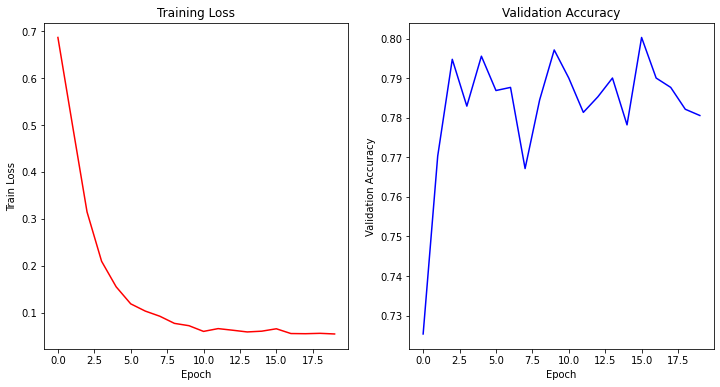


  0%|          | 0/561 [10:41<?, ?it/s]


In [14]:
#@title Training on Roberta Model (roberta-large). Note: Clear Pytorch cache and restart terminal before running
tokenizer = RobertaTokenizer.from_pretrained("roberta-large")
model = RobertaForSequenceClassification.from_pretrained("mrm8488/roberta-large-finetuned-wsc")

# get parameters from preprocessor
init_seed = proc.get_model_arg('init_seed')
proc.set_model_arg('verbose', False)

device = check_gpu()
set_seed(init_seed)

# We'll also set the model to the device that we defined earlier (default is CPU)
model = model.to(device)
epoch_loss = train(model, tokenizer, proc, device,
                   early_stopping = True)

In [ ]:
#@title Prediction on Roberta Model (roberta-large)
## Load best model
model_path = "./model_checkpoint/roberta1.bin"
tokenizer = RobertaTokenizer.from_pretrained("roberta-large")
model = RobertaForSequenceClassification.from_pretrained("mrm8488/roberta-large-finetuned-wsc")
model = load_model (model, model_path)
model.to(device)

predictions = predict(model, tokenizer, proc, device)